<a href="https://colab.research.google.com/github/sebastianmunozvasq/Portfolio-SMV/blob/Problems-with-initial-and-boundary-values/FTCS_method_one_dimensional_non_stationary_convective_cooling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Computational implementation of the FTCS method to solve the one-dimensional non-stationary convective cooling of a bar.



It is desired to know the temperature profile in a cylindrical aluminum bar of very thin radius and length $L = 1 m$. We will consider the axial coordinate as $z$ and that heat transfer occurs only in this direction.

* At $z = 0$, the rod is attached to a very large hot body whose temperature is constant and equal to $T_w = 400 K$.
* At $z = L$, axial heat transfer can be neglected since the cross-sectional area of the bar is very small.
* At $t = 0$, which represents the beginning of the process, the temperature of the whole bar is equal to $T_0 = 400 K$.
* Over time, the bar cools by natural convection from the surroundings characterized by a convection coefficient $h = 20 Wm^{-2}K^{-1}$ and an ambient temperature $T_{\infty} = 298 K$.
* The thermal diffusivity of the bar is $\alpha = 9.586$ $\times$ $10^{-5}$ m s $^{-2}$.
* The diameter of the bar is $d_i = 5,08$ cm.
* The specific heat of aluminum is approximately $\hat{c}_p = 897$ J / kg / K.

The differential balance of this system produces the following partial differential equation

$$ \frac{\partial T}{\partial t} = \alpha \frac{\partial^2 T}{\partial z^2} - \frac{4h}{\rho \hat{c}_p d_i} (T-T_{\infty}) $$

Subject to initial condition

IC: $T(z, t=0) = T_0 = 400 K$

And the boundary conditions:

BC1: $ T(z=0, t) = T_w = 400 K $

BC2: $  \frac{\partial T}{\partial z} (z=L, t) = 0 $

Next, we proceed with the following steps to solve the IBP:

1. Discretize the resulting differential equation using finite differences in space and time 2.
2. Implement a numerical algorithm to find the solution to the system during the first 3600 seconds of the process.

### Part 1)

We will use the FTCS method. Let $j$ and $j+1$ be the time of the current iteration and the time of the next iteration, respectively. These will appear in superscripts next to the discretized variable. In the subscripts will appear the indices associated with the nodes coming from the spatial discretization of the geometric domain. Finally, we note that convective cooling constitutes a heat sink term. When discretizing this term, the temperature as a continuous variable is replaced by the temperature of the central node $ i $. By applying the FTCS method, the following discretized equation is obtained:

$$ \frac{T_i^{j+1}-T_i^{j}}{\Delta t} = \alpha \frac{T_{i+1}^j - 2 T_{i}^j + T_{i-1}^j}{\Delta z ^2} - \frac{4h}{\rho \hat{c}_p d_i} (T^{j}_i-T_{\infty})  $$

By rearranging terms, we obtain the iteration to find the evolution of the system:

$$ T_i^{j+1} = T_i^{j} +  \Delta t \left( \alpha\frac{T_{i+1}^j - 2 T_{i}^j + T_{i-1}^j}{\Delta z ^2} - \frac{4h}{\rho \hat{c}_p d_i} (T^{j}_i-T_{\infty}) \right), \hspace{0.5cm} 1 \leq i \leq N_z - 1$$

This equation is valid for all interior nodes. The first and last nodes are denoted by $i = 0$ and $i = N_z$, respectively. For these nodes, the evolution equation is determined by the boundary conditions of the problem. We can matrix write this equation as follows,

$$ \mathbf{T}^{j+1} = \mathbf{T}^{j} + \Delta t \cdot (\mathbf{A} \mathbf{T}^{j} + \mathbf{b})  $$

Writing this iteration in a matrix form allows us to greatly reduce the computational time required to compute the solution. This is because we replace a native Python loop with a matrix multiplication in NumPy. Since much of the NumPy module is programmed in a high-level language such as C++, this matrix multiplication is much faster.

Part 2) Implementation of the numerical method

We import the necessary modules

In [ ]:
# Scientific computing
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Colormaps
from matplotlib import cm

# Special functions
from scipy.special import erf, erfc


We define the initial temperature and the temperature at the end $z = 0$.

In [ ]:
# Initial temperature of the bar
T_0 = 400  # K

# Temperature at z = 0
T_w = 400  # K


We define the physical parameters associated with the partial differential equation:

In [ ]:
# Thickness of the bar
L = 1  # m

# Thermal diffusivity
alpha = 9.586e-5  # m^2/s

# Density of the aluminum bar
rho = 2700  # kg/m^3

# Specific heat capacity at constant pressure
c_p = 897  # J / kg / K

# Diameter of the bar
d_i = 0.0254  # m

# Natural convection heat transfer coefficient
h = 20  # W/m^2/K


We define the simulation parameters

In [ ]:
# Number of nodes in the z dimension
n_z = 101

# Time step
dt = 0.5  # s

# Initialize the mesh
z = np.linspace(0, L, n_z + 1)

# Mesh spacing
dz = L / (n_z - 1)

# Initial condition
T = np.ones(n_z + 1) * T_0

# Initial time
t_0 = 0

# Final time
t_f = 3600  # s


We construct the coefficient matrix and fill it row by row for the interior nodes. These coefficients come from the PDE discretization.

In [ ]:
# Create the matrix
A = np.zeros([n_z + 1, n_z + 1])

# Iteration
for i in range(1, n_z):
    # Coefficients for the left node, (i-1)
    A[i, i-1] = alpha / (dz**2)

    # Coefficients for the central node, i
    A[i, i] = -2 * alpha / (dz**2) - 4 * h / (rho * c_p * d_i)

    # Coefficients for the right node, i + 1
    A[i, i+1] = alpha / (dz**2)


We construct the vector $b$ which has the same dimension as the temperature,

In [ ]:
# Ambient temperature
T_inf = 298 # K

# Right-hand side vector
b = np.ones(len(T)) * 4 * h / (rho * c_p * d_i) * T_inf


Discretizing the Dirichlet boundary condition at $z = 0$, we have

$$ T^{j}_{0} = T_w $$

In [ ]:
# As the temperature of the first node does not change with time, the coefficient associated with this temperature in the matrix A is set to zero
A[0, 0] = 0

# We also set the right-hand side vector for the first node to zero
b[0] = 0


Discretizing the Neumann boundary condition at $z = L$, using second-order centered differences

$$ 3T^{j}_{N_z} - 4T^{j}_{N_z-1} + 1 T^{j}_{N_z-2}  = 0$$

In [ ]:
# Second-order boundary condition

A[-1, -1] = 3
A[-1, -2] = -4
A[-1, -3] = 1

# Remains zero because it is a homogeneous boundary condition
b[-1] = 0


We verify that the sparse matrix using the command `ax.spy`.

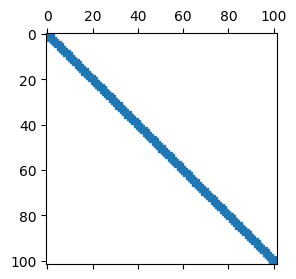

In [ ]:
# Create a 3 x 3 subplot
fig, ax = plt.subplots(1, 1, figsize=[3, 3])

# Plot the sparsity pattern of the matrix
ax.spy(A, markersize=3)
plt.show()


In NumPy, the product between a matrix and a vector is computed using the syntax `np.dot(A,T)`. Before constructing the iteration of the temperature evolution, we test the syntax for one iteration in order to intuitively validate the construction of the matrix A
$$ \mathbf{T}^{j+1} = \mathbf{T}^{j} + \Delta t \cdot (\mathbf{A} \mathbf{T}^{j} + \mathbf{b})  $$

Where `T_new` stands for $\mathbf{T}^{j+1}$ y Where `T` stands for $\mathbf{T}^{j}$.

In [ ]:
# Example of one iteration
T_new = T + (np.dot(A, T) + b) * dt

# Correct the second-order boundary condition with a separate line
T_new[-1] = (4 * T_new[-2] - T_new[-3]) / 3

# Explore the variable
T_new


array([400.        , 399.93367607, 399.93367607, 399.93367607,
       399.93367607, 399.93367607, 399.93367607, 399.93367607,
       399.93367607, 399.93367607, 399.93367607, 399.93367607,
       399.93367607, 399.93367607, 399.93367607, 399.93367607,
       399.93367607, 399.93367607, 399.93367607, 399.93367607,
       399.93367607, 399.93367607, 399.93367607, 399.93367607,
       399.93367607, 399.93367607, 399.93367607, 399.93367607,
       399.93367607, 399.93367607, 399.93367607, 399.93367607,
       399.93367607, 399.93367607, 399.93367607, 399.93367607,
       399.93367607, 399.93367607, 399.93367607, 399.93367607,
       399.93367607, 399.93367607, 399.93367607, 399.93367607,
       399.93367607, 399.93367607, 399.93367607, 399.93367607,
       399.93367607, 399.93367607, 399.93367607, 399.93367607,
       399.93367607, 399.93367607, 399.93367607, 399.93367607,
       399.93367607, 399.93367607, 399.93367607, 399.93367607,
       399.93367607, 399.93367607, 399.93367607, 399.93

We can notice that the bar temperature decreased by approximately 0.1 K after one time step. We are now in a position to calculate the time-dependent temperature profile:

In [ ]:
# Initial integration time
t = 0

# Final integration time
t_max = 1800

# We will save the results after 300 s
write_interval = 300

# List to accumulate times where temperature profiles are saved
t_vec = []

# Generate a copy of the temperature
T_old = np.copy(T)

# List with temperature profiles for each write_interval
T_num = []

# Evolution equation from t = 0 to t_max
while t < t_max:
    # Update temperatures
    T_new = T_old + (np.dot(A, T_old) + b) * dt
    T_new[-1] = (4 * T_new[-2] - T_new[-3]) / 3

    # Advance the time
    t += dt
    # print(t)

    T_old = np.copy(T_new)

    # Save the temperature profile and time
    if (t % write_interval) < 0.9 * dt:
        T_num.append(T_new)

        # Save the time
        t_vec.append(t)


Routine for plotting

<ipython-input-14-1004ed3e1a12>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cividis = cm.get_cmap("cividis", n_temp)


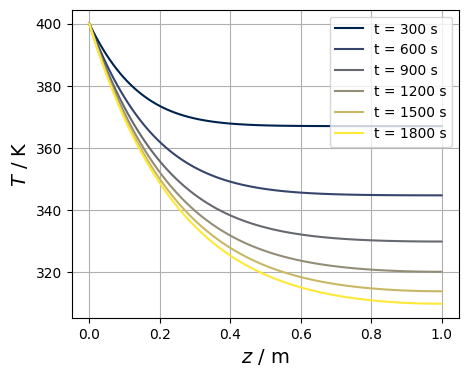

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=[5, 4])

# Total number of temperature profiles to plot
n_temp = len(T_num)

# Use an inclusive color map
cividis = cm.get_cmap("cividis", n_temp)
colour = [cividis(i / n_temp) for i in range(n_temp)]

for k in range(len(T_num)):
    plt.plot(z, T_num[k], color=colour[k], label="t = %.0f s" % t_vec[k])

plt.xlabel('$z$ / m', size=14)
plt.ylabel('$T$ / K', size=14)
plt.grid()
plt.legend()
plt.show()

## Calculation of quantities of engineering interest during non-stationary one-dimensional convective cooling of a bar.



### Item 1: Heat flux at the beginning of the bar

The heat flux at the beginning of the bar is equivalent to the heat flux removed from the hot body at each time. This quantity is relevant for the design of heat exchangers with extended surfaces, such as fins. In this example, we are analyzing a somewhat simpler physical case, however the methodology is equally applicable.

The heat flow at the beginning of the bar as a function of time is defined by Fourier's Law:

$$ \dot{Q}|_{z=0} = -k A_{t}  \frac{\partial T}{\partial z} |_{z=0} $$

Where $k = \alpha \rho \hat{c}_p$ is the thermal conductivity in W/m/K, $A_t = \pi d_i^2/4$ is the cross-sectional area of the bar.

Numerically, we can approximate the temperature gradient at $z=0$ using first order forward finite differences:

$$  \frac{\partial T}{\partial z} |_{z=0} = \frac{-3 T_{0}^j + 4 T_1^j - T_2^j }{2\Delta z} $$

Implementation:

In [ ]:
# Thermal conductivity
k = alpha * rho * c_p

# Cross-sectional area
A_t = np.pi * d_i ** 2 / 4

# Print the thermal conductivity and cross-sectional area values
print("The thermal conductivity of the bar is k = %.3f W/m/K" % k)
print("The cross-sectional area of the bar is A_t = %.3e m^2" % A_t)

def flujo_calor_z0(k, A_t, T, dz):
    '''
    Calculates the heat flux at z = 0 for the
    corrective cooling of a bar, using
    second-order forward finite differences
    for the approximation of the first derivative
    '''

    dTdz_z0 = (-3 * T[0] + 4 * T[1] - T[2]) / (2 * dz)
    return -1 * k * A_t * dTdz_z0


The thermal conductivity of the bar is k = 232.163 W/m/K
The cross-sectional area of the bar is A_t = 5.067e-04 m^2


In [ ]:
# Initial integration time
t = 0

# Final integration time
t_max = 1800

# Record results every 600 s
write_interval = 300

# List to accumulate the times when heat flux is recorded
t_vec = []

# Copy of the initial temperature profile
T_old = np.copy(T)

# List to store the heat flux at z = 0
Q_z0 = []

while t < t_max:
    # Compute the new temperature profile
    T_new = T_old + (np.dot(A, T_old) + b) * dt
    T_new[-1] = (4 * T_new[-2] - T_new[-3]) / 3

    # Record the heat flux at z = 0
    Q_z0.append(flujo_calor_z0(k, A_t, T_new, dz))

    # Record the time
    t_vec.append(t)

    # Update time and temperature profile
    t += dt
    T_old = np.copy(T_new)

# Convert time and Q_z0 lists to numpy arrays
t_vec = np.array(t_vec)
Q_z0 = np.array(Q_z0)


#### Graphic

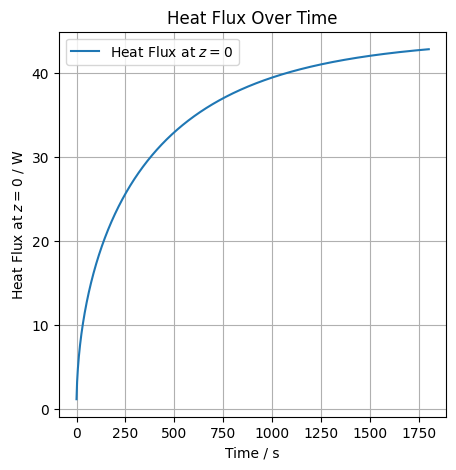

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=[5,5])
plt.plot(t_vec, Q_z0, label='Heat Flux at $z = 0$')
plt.xlabel('Time / s')
plt.ylabel('Heat Flux at $z = 0$ / W')
plt.title('Heat Flux Over Time')
plt.grid(True)
plt.legend()
plt.show()


### Topic 2: Heat flux removed by natural convection as a function of time.

The flux of heat removed by natural convection, $\dot{Q}_{nc}$ is equal to the integral of Newton's Cooling Law over the area of the cylindrical mantle of the bar:

$$ \dot{Q}_{nc} = \int_0^L \int_0^{2 \pi} h(T-T_{\infty}) (R d\theta dz)  $$

Since the profile has angular symmetry, the temperature is a function only of the axial coordinate and not of the angle. Thus, the integral simplifies to:

$$ \dot{Q}_{nc} = 2 \pi R h \int_0^L  (T-T_{\infty}) dz  $$

We will use the [trapezoidal rule for numerical integration](https://imperial-metricmaths.mobius.cloud/105/110/assignments/497). Applying this rule, the integral at each time instant $j$ can be approximated as follows:

$$\int_0^L  (T-T_{\infty}) dz \approx \sum_{i=0}^{N_z-1} \frac{[(T_i^j-T_{\infty}) + (T_{i+1}^j-T_{\infty})]}{2} \cdot \Delta z$$


In [ ]:


def Q_natconv(R, h, T, T_inf, dz):
    '''
    Calculates the heat removed by natural convection
    during the transient one-dimensional cooling
    of a solid bar.

    Parameters:
    R (float): Radius of the bar (m).
    h (float): Convective heat transfer coefficient (W/m^2/K).
    T (array-like): Temperature distribution along the bar.
    T_inf (float): Ambient temperature (K).
    dz (float): Spatial step size (m).

    Returns:
    float: Total heat removed by convection (W).
    '''
    # Integral calculated with the trapezoidal method
    I = np.sum(((T[:-1] - T_inf) + (T[1:] - T_inf)) / 2 * dz)

    # Alternative: verify that the same value is obtained
    # I = np.trapz((T - T_inf), z)

    return 2 * np.pi * R * h * I


In [ ]:
# Initial integration time
t = 0

# Final integration time
t_max = 1800

# Recording interval for results
write_interval = 300

# List to accumulate times for which heat flux is recorded
t_vec = []

# Create a copy of the initial temperature
T_old = np.copy(T)

# List to store the heat flux at z = 0
Q_z0 = []

# List to store the heat flux removed by natural convection
Q_nc = []

# Define the radius as an auxiliary variable
R = d_i / 2

while t < t_max:
    # Compute the new temperature profile
    T_new = T_old + (np.dot(A, T_old) + b) * dt
    T_new[-1] = (4 * T_new[-2] - T_new[-3]) / 3

    # Record the heat flux at z = 0
    Q_z0.append(flujo_calor_z0(k, A_t, T_new, dz))

    # Record the heat flux removed by natural convection
    Q_nc.append(Q_natconv(R, h, T_new, T_inf, dz))

    # Record the time
    t_vec.append(t)

    # Update time
    t += dt
    # print(t)

    # Update the old temperature profile
    T_old = np.copy(T_new)

# Convert lists to arrays
t_vec = np.array(t_vec)
Q_z0 = np.array(Q_z0)
Q_nc = np.array(Q_nc)


#### Visualization

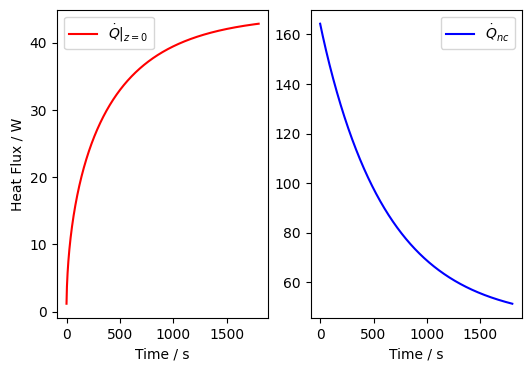

In [ ]:
# The subplots command allows for plotting two graphs in one
fig, axs = plt.subplots(1, 2, figsize=[6, 4])

# Plot the heat flux at z = 0 in the first graph
axs[0].plot(t_vec, Q_z0, color='red', label='$\dot{Q}|_{z=0}$')

# Axis labels for the first graph
axs[0].set_xlabel('Time / s')
axs[0].set_ylabel('Heat Flux / W')

# Display legend for the first graph
axs[0].legend()

# Plot the natural convection heat flux in the second graph
axs[1].plot(t_vec, Q_nc, color='blue', label='$\dot{Q}_{nc}$')

# X-axis label for the second graph
axs[1].set_xlabel('Time / s')

# Display legend for the second graph
axs[1].legend()

# Show the plot
plt.show()


### Topic 3: Macroscopic energy balance

What we have just done is to calculate important quantities appearing in macroscopic energy balances from results obtained from microscopic balances. To find the (negative) heat accumulation in the bar, recall that the macroscopic energy balance can be written in general terms as:

$$ \text{entry} - \text{exit} + \text{net generation} = \text{accumulation}$$.

Since there is no net generation, the energy accumulation is equal to the heat input to the bar at $z = 0$ minus the heat output by natural convection through the cylindrical mantle of the bar.

$$ \frac{\partial}{\partial t} \int_V (\rho \hat{c}_p T) dV = -k A_{t}  \frac{\partial T}{\partial z} |_{z=0} - \int_0^L \int_0^{2 \pi} h(T-T_{\infty}) (R d\theta dz) =  \dot{Q}|_{z=0} - \dot{Q}_{nc}$$

Then, we can add one more graph to our previous graph:

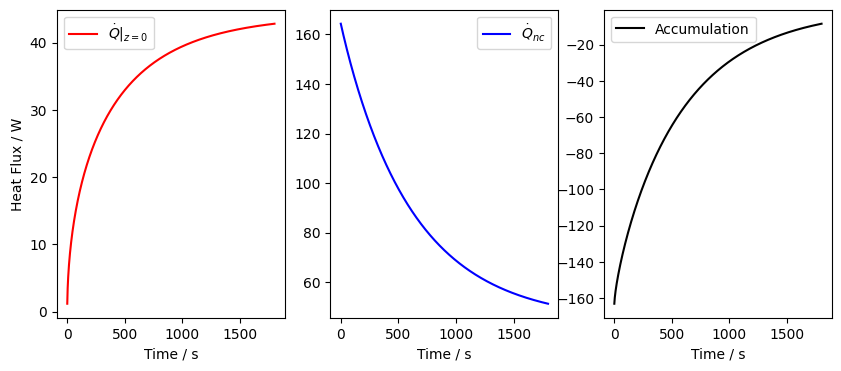

In [ ]:
# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=[10, 4])

# Plot the heat flux at z = 0 in the first subplot
axs[0].plot(t_vec, Q_z0, color='red', label='$\dot{Q}|_{z=0}$')

# Plot the natural convection heat flux in the second subplot
axs[1].plot(t_vec, Q_nc, color='blue', label='$\dot{Q}_{nc}$')

# Plot the accumulation (difference between fluxes) in the third subplot
axs[2].plot(t_vec, (Q_z0 - Q_nc), color='black', label='Accumulation')

# Set x-axis labels for all subplots
axs[0].set_xlabel('Time / s')
axs[1].set_xlabel('Time / s')
axs[2].set_xlabel('Time / s')

# Set y-axis label for the first subplot
axs[0].set_ylabel('Heat Flux / W')

# Add legends to the subplots
axs[0].legend()
axs[1].legend()
axs[2].legend()

# Show the plot
plt.show()
